## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [ ]:
# Today's cameras all use lenses which make 2D image distort, so called camera calibration problem
# There are two common distortion:
# (1) Radial distortion, which makes stright lines appear curved, or objects appear more or less curved 
#     than the they actually are.
# (2) tangential distorion, which occurs 
#     because image taking lense is not aligned perfectly parrllel to the imaging plane.
#
# So this part is the practice to undistort the images effected by both radial and tangential distortion.

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt5

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
# use numpy mgrid function to generate the coordinates values for a given grid size.
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners in distorted calibration images.
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard's inner corners,
    # (x, y) should pass only points where two black and two white squares intersects.
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners to see what was detected.
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)
        

# cv2.destroyAllWindows()


import pickle

img = cv2.imread('../camera_cal/calibration1.jpg')

# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
#
# feed objpoints, imgpoints, and shape of the grayscale image into calibrateCamera function 
# to calculate the distortion cofficients (dist)
# and the camera matrix that we need to transform 3D object points to 2D image points
#
# mtx: Camera Matrix, which only depends on the camera only. so once calculated, it can be stored for future purposes.
# dist: Distortion coefficients, which depends on samples. so once calculated, it can be reused onto the same things 
#       as samples with different angles and orientation.
def store_dist_and_mtx(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    print("mtx: ", mtx)
    print("dist: ", dist)
    # we only calculate once and store it into pickle 
    # so that we could reuse mtx and dist on every chessboard images in camera_cal folder.
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump( dist_pickle, open('mtx_and_dist_pickle.p', 'wb'))

store_dist_and_mtx(img, objpoints, imgpoints)

## And so on and so forth...

In [ ]:
# Apply a distortion correction to raw images.
with open('mtx_and_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

%matplotlib inline

for img in images:
    index = img.rfind('/') + 1
    filename = img[index:]
    img = cv2.imread(img)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('../output_images/undistort_images/'+filename, undist_img)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=50)
# ax2.imshow(undistorted)
# ax2.set_title('Undistorted Image', fontsize=50)
# plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

In [28]:
from camera_calibrate import CameraCalibration
import glob
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline

In [2]:
images = glob.glob('../camera_cal/calibration*.jpg')
cal = CameraCalibration(images)

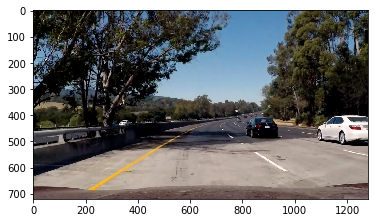

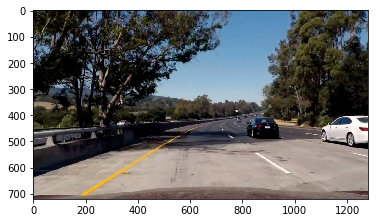

In [3]:
img = mpimg.imread('../test_images/test5.jpg')


plt.imshow(img)
plt.show()

img = cal(img)

plt.imshow(img)
plt.show()

In [37]:
# Use color transforms, gradients, etc., to create a thresholded binary image.

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), debug=False):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    if debug == True:
        plt.imshow(binary_output, cmap='gray')
        plt.show()
    
    return binary_output

def magnitude_thresh(img, sobel_kernel=3, thresh=(0, 255), debug=False):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gredient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    gradmag = (255*gradmag/np.max(gradmag)).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    if debug == True:
        plt.imshow(binary_output, cmap='gray')
        plt.show()
    
    return binary_output

def direction_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2), debug=False):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    if debug == True:
        plt.imshow(binary_output, cmap='gray')
        plt.show()    
    
    return binary_output

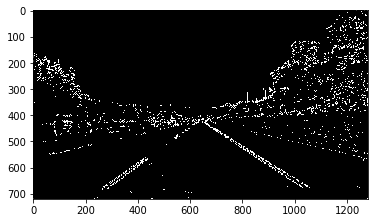

In [40]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(40, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(40, 100))
mag_binary = magnitude_thresh(img, sobel_kernel=9, thresh=(30, 100))
dir_binary = direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) | (mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray');

In [41]:
def hls_select(img, channel='S', thresh=(0, 255), debug=False):
    """
        Apply threshold on image with hls colorspace.
        
        Parameters
        ----------
        img          : RGB image.
        channel      : Select channel to apply threshold on. If channel is 'HLS' then don't apply threshold.
        thresh       : the range is only useful when channel is not 'HLS' or 'hls'.
        debug        : If debug equals True then display result. 
                       
        return
        ----------
        None          : if channel == 'HLS', 'hls'
        binary_output : binary image if channel == 'H', 'L', 'S', 'h', 'l', 's'
    """

    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = channel.upper()
    
    if channel == 'H':
        channel_img = hls[:, :, 0]
    elif channel == 'L':
        channel_img = hls[:, :, 1]
    elif channel == 'S':
        channel_img = hls[:, :, 2]
    elif channel == 'HLS' and debug == True:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]

        axes[0].set_title('H')
        axes[0].set_axis_off()
        axes[1].set_title('L')
        axes[1].set_axis_off()
        axes[2].set_title('S')
        axes[2].set_axis_off()
        axes[0].imshow(H, cmap='gray')
        axes[1].imshow(L, cmap='gray')
        axes[2].imshow(S, cmap='gray')
        return None
    else:
        return None
    
    binary_output = np.zeros_like(channel_img)
    binary_output[(channel_img > thresh[0]) & (channel_img <= thresh[1])] = 1
    
    if debug == True:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
        
        axes[0].set_title('original image')
        axes[0].set_axis_off()
        axes[0].imshow(img)        
        
        axes[1].set_title(channel + ' original')
        axes[1].set_axis_off()
        axes[1].imshow(channel_img, cmap='gray')

        axes[2].set_title(channel + ' with_range_select')
        axes[2].set_axis_off()
        axes[2].imshow(binary_output, cmap='gray')
        plt.show()
        
    return binary_output

In [42]:
def rgb_select(img, channel='R', thresh=(0, 255), debug=False):
    """
        Apply threshold on image with RGB colorspace.
        
        Parameters
        ----------
        img          : RGB image.
        channel      : Select channel to apply threshold on. If channel is 'RGB', then don't apply threshold.
        thresh       : the range is only useful when channel is not 'RGB' or 'RGB'.
        debug        : If debug equals True then display result and return None, 
                       
        return
        ----------
        None          : if channel == 'RGB', 'rgb'.
        binary_output : binary image if channel == 'R', 'G', 'B', 'r', 'g', 'b'
    """

    rgb = img.copy()
    channel = channel.upper()
    
    if channel == 'R':
        channel_img = rgb[:, :, 0]
    elif channel == 'G':
        channel_img = rgb[:, :, 1]
    elif channel == 'B':
        channel_img = rgb[:, :, 2]
    elif channel == 'RGB' and debug == True:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
        R = rgb[:,:,0]
        G = rgb[:,:,1]
        B = rgb[:,:,2]

        axes[0].set_title('R')
        axes[0].set_axis_off()
        axes[1].set_title('B')
        axes[1].set_axis_off()
        axes[2].set_title('G')
        axes[2].set_axis_off()
        axes[0].imshow(R, cmap='gray')
        axes[1].imshow(G, cmap='gray')
        axes[2].imshow(B, cmap='gray')
        plt.show()
        return None
    else:
        return None
    
    binary_output = np.zeros_like(channel_img)
    binary_output[(channel_img > thresh[0]) & (channel_img <= thresh[1])] = 1
    
    if debug == True:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
        
        axes[0].set_title('original image')
        axes[0].set_axis_off()
        axes[0].imshow(img)        
        
        axes[1].set_title(channel + ' original')
        axes[1].set_axis_off()
        axes[1].imshow(channel_img, cmap='gray')

        axes[2].set_title(channel + ' with_range_select')
        axes[2].set_axis_off()
        axes[2].imshow(binary_output, cmap='gray')
        plt.show()
        
    return binary_output

In [44]:
img = mpimg.imread('../test_images/straight_lines2.jpg')
# img = mpimg.imread('../test_images/test5.jpg')
img = cal(img)

r_binary = rgb_select(img, channel='R', thresh=(215, 255), debug=False)
# r_binary = rgb_select(img, channel='R', thresh=(215, 255), debug=True)
s_binary = hls_select(img, thresh=(70, 235), debug=False)
# s_binary = hls_select(img, thresh=(70, 235), debug=True)
gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 150), debug=False)
# gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 150), debug=True)
h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=False)
# h_binary = hls_select(img, channel='h', thresh=(17, 70), debug=True)

combined_binary = np.zeros_like(gradx_binary)
combined_binary[(gradx_binary == 1) | (((h_binary == 1) & (s_binary == 1)) | (r_binary == 1))] = 1

In [123]:
def perspective_transform(img, debug=False):
    # Get image dimensions
    
        
    (h, w) = (img.shape[0], img.shape[1])
    
    roi_y_top = h*0.625
    mid_x = w//2         # midden position of x coordinate in the given image
    offset = 50
    dst_w_offset = 300
    
    src_vertices = np.array([[mid_x + offset, roi_y_top], [w - 160, h], 
                             [200, h], [mid_x - offset, roi_y_top]], dtype=np.int32)
    dst_vertices = np.array([[w - dst_w_offset, 0], [w - dst_w_offset, h], 
                             [dst_w_offset, h]    , [dst_w_offset, 0]], dtype=np.int32)
        
    src = np.float32(src_vertices)
    dst = np.float32(dst_vertices)
    
    # perspective transform is a matrix that's returned by the function
    # getPerspectiveTranform
    M = cv2.getPerspectiveTransform(src, dst)
    
    img_size = (img.shape[1], img.shape[0])
    
    # Apply the transform M to the original image to get the wraped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if debug == True:
        # original img with line
        if img.ndim == 2:
            channel = np.uint8(255*img)
            img_with_lines = np.dstack((channel, channel, channel))
        else:
            img_with_lines = img.copy()
            
        pts = src_vertices.reshape((-1,1,2))
        lines = cv2.polylines(img_with_lines, [pts], True, (255,0,0), thickness=3)
        plt.title('img_with_lines')
        plt.imshow(img_with_lines)
        plt.show()
        
        # flat bird-eye img with line
        if img.ndim == 2:
            channel = np.uint8(255*warped)
            flat_bird_eye_img_with_lines = np.dstack((channel, channel, channel))
        else:
            flat_bird_eye_img_with_lines = warped.copy()
        pts = dst_vertices.reshape((-1,1,2))
        lines = cv2.polylines(flat_bird_eye_img_with_lines, [pts], True, (255,0,0), thickness=3)
        plt.title('flat_bird_eye_img_with_lines')
        plt.imshow(flat_bird_eye_img_with_lines)
        plt.show()

    return warped, M

# perspective_transform(img, debug=True);
bird_eye_binary, M = perspective_transform(combined_binary, debug=False);

In [132]:
# Detect lane pixels and fit to find the lane boundary.

# implement sliding windows and fit a polynomial
# Take a histogram of the bottom half of the image
def bird_eye_view(bird_eye_binary, M, img):
  
    histogram = np.sum(bird_eye_binary[bird_eye_binary.shape[0]//2:, :], axis=0)
    print("here")      
    #     plt.plot(histogram)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((bird_eye_binary, bird_eye_binary, bird_eye_binary))*255

    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(bird_eye_binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzeros pixels in the image
    nonzero = bird_eye_binary.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step throught the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = bird_eye_binary.shape[0] - (window+1)*window_height
        win_y_high = bird_eye_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 5)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 5)
        # identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixls, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Visualize the result
    # Generate x and y values for plotting
    ploty = np.linspace(0, bird_eye_binary.shape[0]-1, bird_eye_binary.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    warp_zero = np.zeros_like(bird_eye_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    Minv = inv(np.matrix(M))
    
    # Warp the lane onto the warped blank image
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
#     plt.show()



#     return out_img, left_fit, right_fit
    return result, left_fit, right_fit

In [133]:
# bird_eye_view(bird_eye_binary, M, img)

In [134]:
def second_bird_eye_view(bird_eye_binary, prev_left_fit, prev_right_fit, M, img):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = bird_eye_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] - margin)) & 
                      (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] - margin)) & 
                       (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, bird_eye_binary.shape[0]-1, bird_eye_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((bird_eye_binary, bird_eye_binary, bird_eye_binary))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    warp_zero = np.zeros_like(bird_eye_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    Minv = inv(np.matrix(M))
    
    # Warp the lane onto the warped blank image
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)


    return result, left_fit, right_fit

In [135]:
# # Determine the curvature of the lane and vehicle position with respect to center.

# %matplotlib inline

# # Generate some fake data to represent lane-line pixels
# ploty = np.linspace(0, 719, num=720) # to cover same y-range as image
# quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# # For each y position generate random x position within +/-50 pixel
# # of the line base position in each case (x=200 for left, and x=900 for right)
# leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51)
#                  for y in ploty])

# rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51)
#                   for y in ploty])

# leftx = leftx[::-1] # Reverse to match top-to-bottom in y
# rightx = rightx[::-1]

# # Fit a second order polynomial to pixel postions in each fake lane line
# left_fit = np.polyfit(ploty, leftx, 2)
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fit = np.polyfit(ploty, rightx, 2)
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# # Plot up the fake data
# # plt.figure(figsize=(15,15))
# mark_size = 3
# plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
# plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
# plt.xlim(0, 1280)
# plt.ylim(0, 720)
# plt.plot(left_fitx, ploty, color='green', linewidth=3)
# plt.plot(right_fitx, ploty, color='green', linewidth=3)
# plt.gca().invert_yaxis()  # to visualize as we do the images

# # Define y-value where we want radius of curvature
# # I'll choose the maximum y-value, corresponding to the bottom of the image
# y_eval = np.max(ploty)
# left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
# right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# print(left_curverad, right_curverad)

In [136]:
# # Define conversions in x and y from pixels space to meters
# ym_per_pix = 30/720   # meters per pixel in y dimension
# xm_per_pix = 3.7/700  # meters per pixel in x dimension

# # Fit new polynomials to x, y in world space
# left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# # Calculate the new radii of curvature
# left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) \
#                 / np.absolute(2*left_fit_cr[0])
# right_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) \
#                  / np.absolute(2*left_fit_cr[0])

# # Now our radius of curvature is in meters
# print(left_curverad, 'm', right_curverad, 'm')

In [137]:
def static_var(varname, value):
    def decorate(func):
        setattr(func, varname, value)
        return func
    return decorate

@static_var("counter", 0)
@static_var("left_fit", None)
@static_var("right_fit", None)
def pipeline(img):
    pipeline.counter += 1
#     img = cal(img)
    
    r_binary = rgb_select(img, channel='R', thresh=(215, 255), debug=False)
    s_binary = hls_select(img, thresh=(70, 235), debug=False)
    gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 150), debug=False)
    h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=False)
    
    combined_binary = np.zeros_like(gradx_binary)
    combined_binary[(gradx_binary == 1) | (((h_binary == 1) & (s_binary == 1)) | (r_binary == 1))] = 1

    bird_eye_binary, M = perspective_transform(combined_binary, debug=False)
    print(bird_eye_binary.shape)
    if pipeline.counter == 1:
        out_img, pipeline.left_fit, pipeline.right_fit = bird_eye_view(bird_eye_binary, M, img)
    else:
        out_img, pipeline.left_fit, pipeline.right_fit = second_bird_eye_view(bird_eye_binary, 
                                                pipeline.left_fit, pipeline.right_fit, M, img)
        
    return out_img

In [138]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [139]:
challenge_output = '../test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip1 = VideoFileClip('../test_videos/challenge.mp4')
challenge_clip = clip1.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

(720, 1280)
here
[MoviePy] >>>> Building video ../test_videos_output/challenge.mp4
[MoviePy] Writing video ../test_videos_output/challenge.mp4


  0%|          | 1/251 [00:00<00:29,  8.51it/s]

(720, 1280)
(720, 1280)


  1%|          | 2/251 [00:00<00:28,  8.77it/s]

(720, 1280)
(720, 1280)


  2%|▏         | 4/251 [00:00<00:26,  9.37it/s]

(720, 1280)


  2%|▏         | 6/251 [00:00<00:25,  9.45it/s]

(720, 1280)
(720, 1280)
(720, 1280)


  4%|▎         | 9/251 [00:00<00:25,  9.35it/s]

(720, 1280)


  4%|▍         | 10/251 [00:01<00:26,  9.17it/s]

(720, 1280)


  4%|▍         | 11/251 [00:01<00:26,  8.93it/s]

(720, 1280)


  5%|▍         | 12/251 [00:01<00:26,  9.06it/s]

(720, 1280)


  5%|▌         | 13/251 [00:01<00:26,  8.97it/s]

(720, 1280)


  6%|▌         | 14/251 [00:01<00:26,  9.02it/s]

(720, 1280)


  6%|▌         | 15/251 [00:01<00:26,  9.08it/s]

(720, 1280)


  6%|▋         | 16/251 [00:01<00:25,  9.20it/s]

(720, 1280)
(720, 1280)
(720, 1280)


  7%|▋         | 18/251 [00:01<00:24,  9.52it/s]

(720, 1280)


  8%|▊         | 20/251 [00:02<00:24,  9.62it/s]

(720, 1280)
(720, 1280)

  8%|▊         | 21/251 [00:02<00:23,  9.64it/s]

  9%|▉         | 23/251 [00:02<00:24,  9.37it/s]

(720, 1280)
(720, 1280)


 10%|▉         | 24/251 [00:02<00:24,  9.37it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 11%|█         | 28/251 [00:02<00:21, 10.21it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 12%|█▏        | 30/251 [00:03<00:21, 10.43it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 14%|█▎        | 34/251 [00:03<00:20, 10.72it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 14%|█▍        | 36/251 [00:03<00:20, 10.50it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 16%|█▌        | 40/251 [00:04<00:19, 10.60it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 17%|█▋        | 42/251 [00:04<00:19, 10.70it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 18%|█▊        | 46/251 [00:04<00:19, 10.48it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 19%|█▉        | 48/251 [00:04<00:20, 10.02it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 21%|██        | 52/251 [00:05<00:19, 10.32it/s]

(720, 1280)
(720, 1280)


 22%|██▏       | 54/251 [00:05<00:19,  9.97it/s]

(720, 1280)
(720, 1280)
(720, 1280)

 23%|██▎       | 57/251 [00:05<00:20,  9.51it/s]


(720, 1280)
(720, 1280)


 24%|██▎       | 59/251 [00:05<00:20,  9.47it/s]

(720, 1280)
(720, 1280)


 24%|██▍       | 61/251 [00:06<00:20,  9.28it/s]

(720, 1280)
(720, 1280)


 25%|██▍       | 62/251 [00:06<00:19,  9.46it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 26%|██▌       | 65/251 [00:06<00:19,  9.63it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 27%|██▋       | 69/251 [00:06<00:18,  9.66it/s]

(720, 1280)
(720, 1280)


 28%|██▊       | 70/251 [00:07<00:18,  9.62it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 29%|██▉       | 73/251 [00:07<00:18,  9.37it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 31%|███       | 77/251 [00:07<00:18,  9.17it/s]

(720, 1280)
(720, 1280)


 31%|███       | 78/251 [00:07<00:19,  8.95it/s]

(720, 1280)
(720, 1280)


 32%|███▏      | 81/251 [00:08<00:18,  9.18it/s]

(720, 1280)
(720, 1280)


 33%|███▎      | 82/251 [00:08<00:18,  9.31it/s]

(720, 1280)
(720, 1280)
(720, 1280)

 34%|███▍      | 86/251 [00:08<00:17,  9.65it/s]


(720, 1280)
(720, 1280)
(720, 1280)


 35%|███▌      | 89/251 [00:09<00:16,  9.56it/s]

(720, 1280)
(720, 1280)
(720, 1280)

 36%|███▋      | 91/251 [00:09<00:16,  9.82it/s]


(720, 1280)


 37%|███▋      | 93/251 [00:09<00:17,  8.98it/s]

(720, 1280)
(720, 1280)


 38%|███▊      | 95/251 [00:09<00:17,  8.85it/s]

(720, 1280)
(720, 1280)


 39%|███▊      | 97/251 [00:09<00:17,  8.84it/s]

(720, 1280)
(720, 1280)


 39%|███▉      | 99/251 [00:10<00:16,  9.25it/s]

(720, 1280)
(720, 1280)


 40%|████      | 101/251 [00:10<00:16,  8.99it/s]

(720, 1280)
(720, 1280)


 41%|████      | 102/251 [00:10<00:16,  9.04it/s]

(720, 1280)
(720, 1280)


 42%|████▏     | 105/251 [00:10<00:16,  9.01it/s]

(720, 1280)
(720, 1280)


 43%|████▎     | 107/251 [00:11<00:15,  9.31it/s]

(720, 1280)
(720, 1280)


 43%|████▎     | 109/251 [00:11<00:16,  8.65it/s]

(720, 1280)
(720, 1280)


 44%|████▍     | 111/251 [00:11<00:16,  8.32it/s]

(720, 1280)
(720, 1280)


 45%|████▌     | 113/251 [00:11<00:16,  8.35it/s]

(720, 1280)
(720, 1280)


 45%|████▌     | 114/251 [00:11<00:15,  8.72it/s]

(720, 1280)
(720, 1280)
(720, 1280)

 47%|████▋     | 117/251 [00:12<00:14,  9.01it/s]


(720, 1280)


 47%|████▋     | 119/251 [00:12<00:14,  9.29it/s]

(720, 1280)
(720, 1280)


 48%|████▊     | 121/251 [00:12<00:14,  8.88it/s]

(720, 1280)
(720, 1280)


 49%|████▊     | 122/251 [00:12<00:14,  8.94it/s]

(720, 1280)
(720, 1280)
(720, 1280)

 50%|█████     | 126/251 [00:13<00:13,  9.24it/s]


(720, 1280)
(720, 1280)
(720, 1280)

 51%|█████▏    | 129/251 [00:13<00:13,  9.25it/s]


(720, 1280)
(720, 1280)


 52%|█████▏    | 130/251 [00:13<00:13,  9.11it/s]

(720, 1280)
(720, 1280)
(720, 1280)

 53%|█████▎    | 134/251 [00:14<00:12,  9.22it/s]


(720, 1280)
(720, 1280)


 54%|█████▍    | 136/251 [00:14<00:12,  9.21it/s]

(720, 1280)
(720, 1280)


 55%|█████▍    | 138/251 [00:14<00:12,  9.16it/s]

(720, 1280)
(720, 1280)


 56%|█████▌    | 140/251 [00:14<00:12,  9.12it/s]

(720, 1280)
(720, 1280)


 57%|█████▋    | 142/251 [00:14<00:11,  9.25it/s]

(720, 1280)
(720, 1280)


 57%|█████▋    | 144/251 [00:15<00:11,  9.26it/s]

(720, 1280)
(720, 1280)


 58%|█████▊    | 146/251 [00:15<00:11,  9.20it/s]

(720, 1280)
(720, 1280)
(720, 1280)

 59%|█████▉    | 149/251 [00:15<00:10,  9.28it/s]


(720, 1280)
(720, 1280)


 60%|█████▉    | 150/251 [00:15<00:10,  9.24it/s]

(720, 1280)
(720, 1280)


 61%|██████    | 153/251 [00:16<00:10,  9.32it/s]

(720, 1280)
(720, 1280)


 61%|██████▏   | 154/251 [00:16<00:10,  9.33it/s]

(720, 1280)
(720, 1280)
(720, 1280)

 63%|██████▎   | 158/251 [00:16<00:10,  9.25it/s]


(720, 1280)
(720, 1280)


 64%|██████▎   | 160/251 [00:16<00:09,  9.38it/s]

(720, 1280)
(720, 1280)


 65%|██████▍   | 162/251 [00:17<00:09,  9.05it/s]

(720, 1280)
(720, 1280)


 65%|██████▌   | 164/251 [00:17<00:09,  9.18it/s]

(720, 1280)
(720, 1280)


 66%|██████▌   | 166/251 [00:17<00:09,  8.94it/s]

(720, 1280)
(720, 1280)


 67%|██████▋   | 168/251 [00:17<00:09,  8.93it/s]

(720, 1280)
(720, 1280)


 68%|██████▊   | 170/251 [00:17<00:09,  8.82it/s]

(720, 1280)
(720, 1280)


 69%|██████▊   | 172/251 [00:18<00:08,  9.21it/s]

(720, 1280)
(720, 1280)


 69%|██████▉   | 174/251 [00:18<00:08,  9.03it/s]

(720, 1280)
(720, 1280)


 70%|███████   | 176/251 [00:18<00:08,  9.05it/s]

(720, 1280)
(720, 1280)


 71%|███████   | 178/251 [00:18<00:08,  8.82it/s]

(720, 1280)
(720, 1280)


 72%|███████▏  | 180/251 [00:19<00:07,  9.12it/s]

(720, 1280)
(720, 1280)


 73%|███████▎  | 182/251 [00:19<00:07,  8.75it/s]

(720, 1280)
(720, 1280)


 73%|███████▎  | 184/251 [00:19<00:07,  8.80it/s]

(720, 1280)
(720, 1280)


 74%|███████▍  | 186/251 [00:19<00:07,  8.71it/s]

(720, 1280)
(720, 1280)


 75%|███████▍  | 188/251 [00:19<00:07,  8.82it/s]

(720, 1280)
(720, 1280)


 76%|███████▌  | 190/251 [00:20<00:07,  8.61it/s]

(720, 1280)
(720, 1280)


 76%|███████▋  | 192/251 [00:20<00:06,  8.69it/s]

(720, 1280)
(720, 1280)


 77%|███████▋  | 194/251 [00:20<00:06,  8.46it/s]

(720, 1280)
(720, 1280)


 78%|███████▊  | 196/251 [00:20<00:06,  8.71it/s]

(720, 1280)
(720, 1280)


 79%|███████▉  | 198/251 [00:21<00:06,  8.72it/s]

(720, 1280)
(720, 1280)


 80%|███████▉  | 200/251 [00:21<00:05,  9.07it/s]

(720, 1280)
(720, 1280)


 80%|████████  | 202/251 [00:21<00:05,  9.06it/s]

(720, 1280)
(720, 1280)


 81%|████████▏ | 204/251 [00:21<00:05,  8.58it/s]

(720, 1280)
(720, 1280)


 82%|████████▏ | 206/251 [00:22<00:05,  8.02it/s]

(720, 1280)
(720, 1280)


 83%|████████▎ | 208/251 [00:22<00:05,  7.69it/s]

(720, 1280)
(720, 1280)


 84%|████████▎ | 210/251 [00:22<00:04,  8.23it/s]

(720, 1280)
(720, 1280)


 84%|████████▍ | 212/251 [00:22<00:04,  8.47it/s]

(720, 1280)
(720, 1280)


 85%|████████▌ | 214/251 [00:22<00:04,  8.91it/s]

(720, 1280)
(720, 1280)


 86%|████████▌ | 216/251 [00:23<00:03,  9.06it/s]

(720, 1280)
(720, 1280)


 87%|████████▋ | 218/251 [00:23<00:03,  9.14it/s]

(720, 1280)
(720, 1280)


 87%|████████▋ | 219/251 [00:23<00:03,  9.09it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 89%|████████▉ | 223/251 [00:23<00:03,  9.11it/s]

(720, 1280)
(720, 1280)


 89%|████████▉ | 224/251 [00:24<00:02,  9.28it/s]

(720, 1280)
(720, 1280)


 90%|█████████ | 227/251 [00:24<00:02,  9.40it/s]

(720, 1280)
(720, 1280)


 91%|█████████ | 228/251 [00:24<00:02,  9.54it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 92%|█████████▏| 232/251 [00:24<00:02,  9.21it/s]

(720, 1280)
(720, 1280)


 93%|█████████▎| 234/251 [00:25<00:01,  9.38it/s]

(720, 1280)
(720, 1280)


 94%|█████████▎| 235/251 [00:25<00:01,  9.13it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 95%|█████████▌| 239/251 [00:25<00:01,  9.32it/s]

(720, 1280)
(720, 1280)


 96%|█████████▌| 240/251 [00:25<00:01,  9.47it/s]

(720, 1280)
(720, 1280)
(720, 1280)

 97%|█████████▋| 243/251 [00:26<00:00,  9.49it/s]


(720, 1280)


 98%|█████████▊| 245/251 [00:26<00:00,  9.73it/s]

(720, 1280)
(720, 1280)
(720, 1280)

 98%|█████████▊| 247/251 [00:26<00:00,  9.42it/s]


(720, 1280)
(720, 1280)
(720, 1280)


100%|██████████| 251/251 [00:26<00:00,  9.56it/s]

(720, 1280)
(720, 1280)


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/challenge.mp4 

CPU times: user 26.9 s, sys: 6.23 s, total: 33.1 s
Wall time: 28.4 s


In [76]:
bird_eye_binary.shape[0]

720

In [140]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
class line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits 

In [ ]:
# Warp the detected lane boundaries back onto the original image.
# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.